## A simple neural network classifier

<img src="iris_three_species.jpg" style="box-shadow: none;" width="100%">

_Iris setosa, Iris versicolor and Iris virginica_

Firstly we need to load our data into our program. In a real-world case, this could come from any source, a CSV file, a SQL database, an Excel file etc. In our case today, we'll be using an example data set from scikit-learn:

In [1]:
from sklearn.datasets import load_iris

X, y = load_iris(as_frame=True, return_X_y=True)

In [2]:
X.assign(target=y)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0         0  
1         0  
2         0  
3         0  
4         0  
..      ...  
145       2  
146       2  
147       2  
148       2  
149       2  

[150 rows x 5 columns]

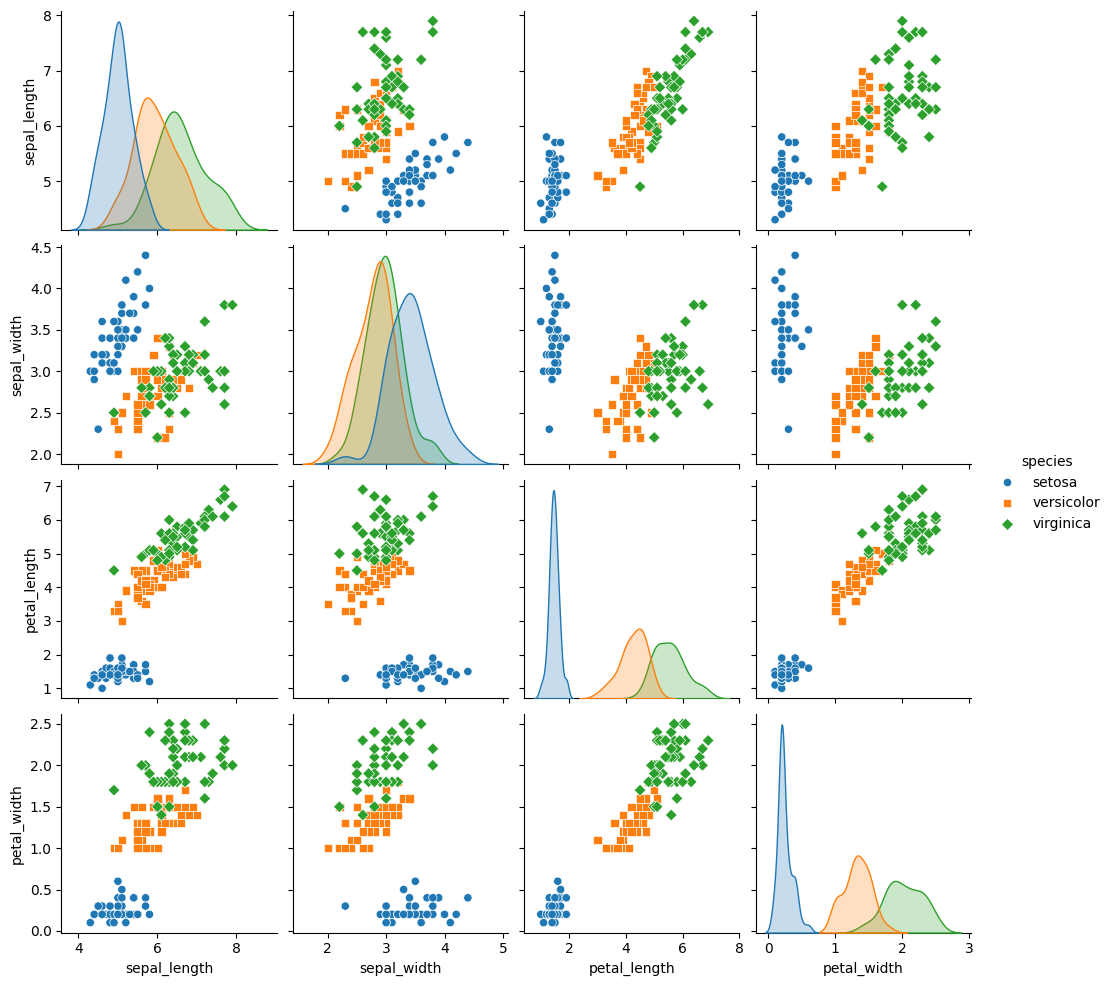

In [3]:
import seaborn as sns
iris = sns.load_dataset("iris")
f = sns.pairplot(data=iris, hue="species", markers=["o", "s", "D"])

Once we have the data loaded in, we need to split it to keep half aside for validation:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

TensorFlow can work with numpy array and Pandas DataFrames directly, but it also provides its own container for data called a `Dataset`. This type can hold the data as well as help prepare it to be used by the system. You can turn a `DataFrame` into a `Dataset` using the `from_tensor_slices` function:

In [5]:
import tensorflow as tf

train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2024-01-19 10:50:23.064279: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:50:23.101522: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 10:50:23.101556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 10:50:23.102396: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 10:50:23.107705: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 10:50:24.146234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

If you get a warning at this point about NUMA or GPU devices, like I did above, it's fine. It means that your model will not train as fast as if you have a GPU set up, but it will work for the session.

## Data preparation

Once we have our data as a `Dataset`, we can prepare it for use by TensorFlow. Depending on the problem you're solving, you might need to do different things to your data.

In our case today, we have quite a small input set of data and so likely the neural network will not learn enough by simply looking at each example in it once. To solve this, we will show each training example to the model multiple times. We can do this by using the `repeat(20)` method on the `Dataset` which will show each example to the network 20 times.

The downside of doing this is that the model will always see the same example in the same order each time round. This can cause it to not learn the general shape of the data as well so it's a good idea to randomise the order as well. This can be done with the `shuffle()` method. This method also needs the number of items to grab each time it shuffles them. Setting it to 1000 means that it will grab the first 1000 examples, shuffle them and then grab the next 1000, shuffle them etc.

Finally, as an optimisation, we can show multiple examples to the network, all in one go. On larger data sets this can significantly increase the speed of training, and on any dataset will make the computed gradients smoother. A common choice is a batch size of 32, but you will sometimes be limited by available memory in some cases.

In [6]:
train = train.repeat(20).shuffle(1000).batch(32)

We need to ensure that our validation data set is the same dimensionality so we need to batch it too. It doesn't really matter what batch size you choose here, so a choice of `1` or `32` would work fine:

In [7]:
test = test.batch(1)

## Model creation

The model creation step is where most of the ingenuity in working with neural networks comes from. It is the choice of the number of neurons, and how they are interconnected that decide the capabilities of a network.

In principle you have completely free reign to connect together neurons however you which, as long as you have a place for the inputs to arrive, and a was of extracting an output. However, most problems can be solved with a [feed-forward network](https://en.wikipedia.org/wiki/Feedforward_neural_network) where each layer only connects to the layer before it. This is managed by using the [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)  model.

We need to tell the model the information about each layer. For our purposes here, we will define a relatively simple network with two hidden layers and one output layer. Each node in each hidden layer will be connected to all the nodes in the previous layer. This is called a *densely-connected* layer and is represented with `tf.keras.layers.Dense`.

Each dense layer needs two pieces of information:
1. How may nodes are in that layer
2. What *activation function* is used on the nodes in the layer.

We'll make each hidden layer 10 neurons for now, and use the [rectifier or ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) as our activation function. This is a good choice in many situations, and will suffice for now.

Our output layer needs a slightly different approach. For an output layer on a multi-class classifier, you will usually want a node per class. We have three species, so we have three nodes. In order to normalise the outputs of the network, we use the [`softmax`](https://www.tensorflow.org/api_docs/python/tf/nn/softmax) function which normalised the output of each output node so that they sum to 1.0. This allows you to treat each node's output as a probability.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu),   # hidden layer
    tf.keras.layers.Dense(10, activation=tf.nn.relu),   # hidden layer
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)  # output layer
])

## Describing the training

At each step of the training we need to know "how wrong are we" as a single number. We need this so we know much the weights in the network should be shifted by.

If, for example, for a given run of the network, the output looks like `[0.4, 0.3, 0.3]` (they add up to 1.0 due to the softmax) while the correct label is `0` we need a function to compare them and give us a single "loss" (e.g. `1.13`). This can be some using the *sparse categorical crossentropy* function. This is the loss function any time you have more than two classes (or at least in any case where your classes are encoded as integers `1`, `2`, etc.).

The metrics are there to show us information during training to monitor progress. The *accuracy* metric is a simple percentage of how any examples were predicted correctly.

In [9]:
model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

## Fitting the model to the data

We've now prepared everything we need for the model and we can go ahead and show it some data. There are two main types things you need to provide to it:
1. What data should be used
2. When should it stop training

The former is easily answered as we've prepared all our data already so we pass it our `train` and `test` data sets.

--In order for the network to know how long to keep running we tell it directly. We do this by telling how many steps are in each epoch and how many epochs to run for. Traditionally, a data *epoch* was showing each training example to the network once. However, once we start batching, shuffling and repeating, it becomes a little less well defined. A *step* is a single batch of data being passed through the network so you would usually have `number_of_examples` ÷ `batch_size` steps in each epoch.

There's no mathematical difference between one epoch and the next, the only meaning that it has is that TensorFlow will print a summary of the current loss and accuracy at the end of each epoch. For a network and data set this simple, --

In [10]:
model.fit(
    train,
    validation_data=test,
    epochs=10,
)

Epoch 1/10
70/70 [==============================] - 1s 4ms/step - loss: 1.1344 - accuracy: 0.5085 - val_loss: 0.7537 - val_accuracy: 0.5789
Epoch 2/10
70/70 [==============================] - 0s 1ms/step - loss: 0.6542 - accuracy: 0.6022 - val_loss: 0.5420 - val_accuracy: 0.6579
Epoch 3/10
70/70 [==============================] - 0s 1ms/step - loss: 0.5047 - accuracy: 0.6772 - val_loss: 0.4284 - val_accuracy: 0.8421
Epoch 4/10
70/70 [==============================] - 0s 1ms/step - loss: 0.4300 - accuracy: 0.7973 - val_loss: 0.3654 - val_accuracy: 0.9474
Epoch 5/10
70/70 [==============================] - 0s 2ms/step - loss: 0.3766 - accuracy: 0.8982 - val_loss: 0.3203 - val_accuracy: 0.9474
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 0.3292 - accuracy: 0.9496 - val_loss: 0.2779 - val_accuracy: 0.9737
Epoch 7/10
70/70 [==============================] - 0s 2ms/step - loss: 0.2835 - accuracy: 0.9661 - val_loss: 0.2427 - val_accuracy: 0.9211
Epoch 8/10
70/70 [==

The outputs here are:

<dl>
    <dt>loss</dt>
    <dd>The value of the loss function on the last batch in the epoch, as calculated on the training data</dd>
    <dt>accuracy</dt>
    <dd>The fraction of the entries in the training data set that are classified correctly</dd>
    <dt>val_loss</dt>
    <dd>The value of the loss function on the last batch in the epoch, as calculated on the test/validation data</dd>
    <dt>val_accuracy</dt>
    <dd>The fraction of the entries in the test/validation data set that are classified correctly</dd>
</dl>

The main one to be watching is the `val_accuracy` as that is usually the metric that represents real-world performance.

The other thing to be aware of is that you want the `accuracy` and the `val_accuracy` to be matching each other. If `accuracy` is much better than `val_accuracy`, it suggests overfitting.

## Making predictions

We can use the `model.predict()` method. We must pass it data in the same shape as the data we trained with:

In [11]:
predict_X = [
  [5.1, 3.3, 1.7, 0.5],
  [5.9, 3.0, 4.2, 1.5],
  [6.9, 3.1, 5.4, 2.1],
]

predictions = model.predict(predict_X)

1/1 [==============================] - 0s 83ms/step


To peek at this output, the prediction for the first flower is:

In [12]:
predictions[0]

array([9.9274069e-01, 7.2013992e-03, 5.7959085e-05], dtype=float32)

These numbers represent the probability that this flower is of each of the species given. We can ask which class is the most likely with `argmax()`:

In [13]:
predictions[0].argmax()

0

We can then automate this over all the examples:

In [14]:
for pred_dict, expected in zip(predictions, ["setosa", "versicolor", "virginica"]):
    predicted_index = pred_dict.argmax()
    predicted = load_iris().target_names[predicted_index]
    probability = pred_dict.max()
    tick_cross = "✓" if predicted == expected else "✗"
    print(f"{tick_cross} Prediction is '{predicted}' ({100 * probability:.1f}%), expected '{expected}'")

✓ Prediction is 'setosa' (99.3%), expected 'setosa'
✓ Prediction is 'versicolor' (75.6%), expected 'versicolor'
✓ Prediction is 'virginica' (80.5%), expected 'virginica'


### Exercise

Try altering the network in some of these ways:
- Change the number of hidden layers. Try increasing and decreasing.
- Change the number of nodes in the hidden layers
- Change the number of repeats of the training data
- Change the number of epochs

See if it's possible to simplify the network, while still getting good performance.